<a href="https://colab.research.google.com/github/VISHAL2077/Generative_AI_2025/blob/main/GEN_AI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEN AI PROJECT : 5 GEN AI MODELS

- cnn decoder
- cvae
- cgan
- text2image transformer
- bert2image transformer

# Creating synthetic dataset for shapes with colors

In [44]:
from PIL import Image, ImageDraw
import os, random
import pandas as pd

dataset_dir = "tiny_dataset"
os.makedirs(dataset_dir, exist_ok=True)

shapes = ["circle", "square", "triangle"]
colors = ["red", "green", "blue"]
data = []

for i in range(200):
    shape = random.choice(shapes)
    color = random.choice(colors)
    desc = f"{color} {shape}"
    fname = f"{i}_{shape}_{color}.png"
    data.append((desc, fname))

    img = Image.new("RGB", (64, 64), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    if shape == "circle":
        draw.ellipse((16, 16, 48, 48), fill=color)
    elif shape == "square":
        draw.rectangle((16, 16, 48, 48), fill=color)
    elif shape == "triangle":
        draw.polygon([(32, 16), (16, 48), (48, 48)], fill=color)
    img.save(os.path.join(dataset_dir, fname))

pd.DataFrame(data, columns=["text", "image"]).to_csv("metadata.csv", index=False)

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import torch
import numpy as np

meta = pd.read_csv("metadata.csv")
vectorizer = CountVectorizer()
text_features = vectorizer.fit_transform(meta["text"]).toarray()
text_features = torch.tensor(text_features).float()

# CNN

In [46]:
# CNN Decoder (baseline)
import torch
import torch.nn as nn
from torchvision.utils import save_image

class CNNDecoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 64 * 3),
            nn.Tanh()
        )
    def forward(self, x):
        return self.net(x).view(-1, 3, 64, 64)

model = CNNDecoder(text_features.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

imgs = []
for fname in meta["image"]:
    img = Image.open(os.path.join(dataset_dir, fname)).resize((64, 64))
    imgs.append(np.asarray(img) / 127.5 - 1.0)
real_imgs = torch.tensor(np.stack(imgs)).permute(0, 3, 1, 2).float()

# Train CNN
for epoch in range(100):
    output = model(text_features)
    loss = criterion(output, real_imgs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"CNN Epoch {epoch} | Loss: {loss.item():.4f}")

# Save CNN outputs
torch.save(model.state_dict(), "cnn_model.pth")
save_image(output[:9], "cnn_outputs.png", nrow=3, normalize=True)

CNN Epoch 0 | Loss: 1.0072
CNN Epoch 20 | Loss: 0.1891
CNN Epoch 40 | Loss: 0.0666
CNN Epoch 60 | Loss: 0.0310
CNN Epoch 80 | Loss: 0.0168


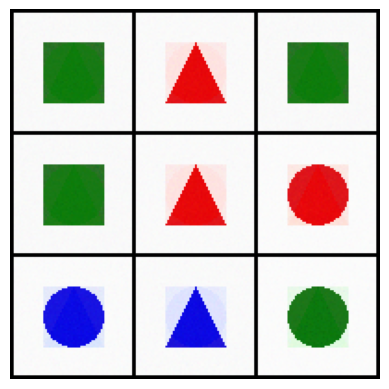

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/cnn_outputs.png'

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

Enter a shape and color (e.g., 'blue square'): RED CIRCLE
Image generated and saved as: generated_red_circle.png


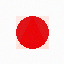

In [48]:
from IPython.display import Image as IPyImage, display
from PIL import Image

def generate_image_from_text(text):
    vec = vectorizer.transform([text.lower()]).toarray()
    vec = torch.tensor(vec).float()
    with torch.no_grad():
        gen_img = model(vec).squeeze(0)
        filename = f"generated_{text.replace(' ', '_').lower()}.png"
        save_image(gen_img, filename, normalize=True)
        print(f"Image generated and saved as: {filename}")
        display(IPyImage(filename))

user_input = input("Enter a shape and color (e.g., 'blue square'): ").strip()
generate_image_from_text(user_input)

# CVAE

In [49]:
class CVAEEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2_mu = nn.Linear(256, latent_dim)
        self.fc2_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar


class CVAEDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64 * 64 * 3)

    def forward(self, z):
        x = torch.relu(self.fc1(z))
        x = self.fc2(x)
        return torch.tanh(x).view(-1, 3, 64, 64)


class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = CVAEEncoder(input_dim, latent_dim)
        self.decoder = CVAEDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # Using KL divergence
    # KL divergence between learned and standard normal distributions
    # We'll assume N(0,1) for simplicity
    # The formula is: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 is exp(logvar)
    # Input values are already processed in the encoder

    # KL divergence term
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL


# Instantiate the model
latent_dim = 64  # Example latent dimension size
model_cvae = CVAE(text_features.shape[1], latent_dim)
optimizer_cvae = torch.optim.Adam(model_cvae.parameters(), lr=1e-3)

# Train the CVAE
for epoch in range(1000):
    output, mu, logvar = model_cvae(text_features)
    loss = vae_loss(output, real_imgs, mu, logvar)
    optimizer_cvae.zero_grad()
    loss.backward()
    optimizer_cvae.step()

    if epoch % 20 == 0:
        print(f"CVAE Epoch {epoch} | Loss: {loss.item():.4f}")

# Save CVAE outputs
torch.save(model_cvae.state_dict(), "cvae_model.pth")
save_image(output[:9], "cvae_outputs.png", nrow=3, normalize=True)

CVAE Epoch 0 | Loss: 2545420.7500
CVAE Epoch 20 | Loss: 548650.2500
CVAE Epoch 40 | Loss: 359179.8125
CVAE Epoch 60 | Loss: 108772.5078
CVAE Epoch 80 | Loss: 37863.8711
CVAE Epoch 100 | Loss: 22066.3867
CVAE Epoch 120 | Loss: 16265.3271
CVAE Epoch 140 | Loss: 13318.4492
CVAE Epoch 160 | Loss: 11895.0322
CVAE Epoch 180 | Loss: 10836.2012
CVAE Epoch 200 | Loss: 10414.0615
CVAE Epoch 220 | Loss: 9873.4648
CVAE Epoch 240 | Loss: 9765.2939
CVAE Epoch 260 | Loss: 8835.3037
CVAE Epoch 280 | Loss: 8713.7949
CVAE Epoch 300 | Loss: 8352.4688
CVAE Epoch 320 | Loss: 8044.7578
CVAE Epoch 340 | Loss: 7933.7134
CVAE Epoch 360 | Loss: 7708.7319
CVAE Epoch 380 | Loss: 7205.5303
CVAE Epoch 400 | Loss: 7080.5493
CVAE Epoch 420 | Loss: 7083.5166
CVAE Epoch 440 | Loss: 6623.5498
CVAE Epoch 460 | Loss: 6381.0400
CVAE Epoch 480 | Loss: 6384.5264
CVAE Epoch 500 | Loss: 6346.2017
CVAE Epoch 520 | Loss: 5978.4111
CVAE Epoch 540 | Loss: 6389.8403
CVAE Epoch 560 | Loss: 6188.8701
CVAE Epoch 580 | Loss: 5650.2827


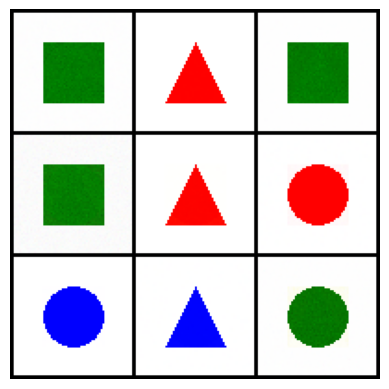

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/cvae_outputs.png'

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

Enter shape and color for CVAE (e.g., 'green triangle'): RED CIRCLE
CVAE image saved as: cvae_generated_red_circle.png


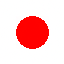

In [51]:
def generate_image_cvae(text):
    vec = vectorizer.transform([text.lower()]).toarray()
    vec = torch.tensor(vec).float()
    with torch.no_grad():
        output, _, _ = model_cvae(vec)
        gen_img = output.squeeze(0)
        filename = f"cvae_generated_{text.replace(' ', '_').lower()}.png"
        save_image(gen_img, filename, normalize=True)
        print(f"CVAE image saved as: {filename}")
        display(IPyImage(filename))

user_input = input("Enter shape and color for CVAE (e.g., 'green triangle'): ").strip()
generate_image_cvae(user_input)

# CGAN

Enter the text description (e.g., 'red circle'): RED CIRCLE
[Epoch 0/100]  D_loss: 0.5085  G_loss: 0.6823
[Epoch 10/100]  D_loss: 0.2359  G_loss: 0.9805
[Epoch 20/100]  D_loss: 0.2454  G_loss: 0.9677
[Epoch 30/100]  D_loss: 0.3503  G_loss: 0.7155
[Epoch 40/100]  D_loss: 0.2482  G_loss: 0.9685
[Epoch 50/100]  D_loss: 0.2527  G_loss: 0.9575
[Epoch 60/100]  D_loss: 0.3109  G_loss: 0.8238
[Epoch 70/100]  D_loss: 0.2830  G_loss: 0.9000
[Epoch 80/100]  D_loss: 0.1456  G_loss: 1.4780
[Epoch 90/100]  D_loss: 0.0535  G_loss: 2.4369
[Epoch 99/100]  D_loss: 0.0946  G_loss: 1.8971


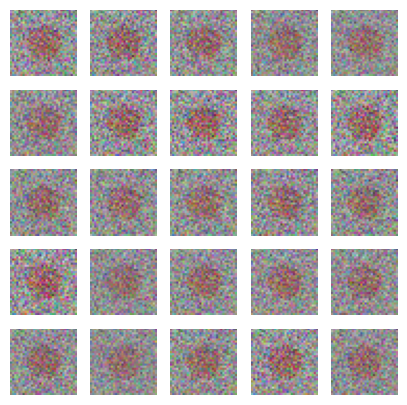

In [88]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --------- Dataset Class ----------
class FilteredShapesDataset(Dataset):
    def __init__(self, csv_file, img_dir, input_text, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.input_text = input_text.lower()

        # Filter images matching description
        self.data = self.data[self.data['text'].str.lower() == self.input_text]
        self.data.reset_index(drop=True, inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.loc[idx, 'image'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# --------- Simple Generator ---------
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# --------- Simple Discriminator ---------
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# --------- Main Training Script ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Ask user input
input_text = input("Enter the text description (e.g., 'red circle'): ").lower()

# 2. Transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 3. Dataset and Dataloader
batch_size = 16
dataset = FilteredShapesDataset(csv_file="metadata.csv", img_dir="tiny_dataset", input_text=input_text, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

if len(dataset) == 0:
    raise ValueError(f"No images found for description '{input_text}'")

# 4. GAN Setup
latent_dim = 100
img_shape = (3, 32, 32)

generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# 5. Training
n_epochs = 100

for epoch in range(n_epochs):
    for imgs in dataloader:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Adversarial ground truths
        valid = torch.ones((batch_size, 1), device=device)
        fake = torch.zeros((batch_size, 1), device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    if epoch % 10 == 0 or epoch == n_epochs-1:
        print(f"[Epoch {epoch}/{n_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

# 6. Generate and Show Samples
generator.eval()
z = torch.randn(25, latent_dim, device=device)
gen_imgs = generator(z)
gen_imgs = gen_imgs * 0.5 + 0.5  # unnormalize

grid = torch.cat([img.unsqueeze(0) for img in gen_imgs], dim=0)
grid = torch.reshape(grid, (-1, 3, 32, 32))

fig, axs = plt.subplots(5, 5, figsize=(5, 5))
cnt = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(grid[cnt].permute(1,2,0).detach().cpu().numpy())
        axs[i,j].axis('off')
        cnt += 1
plt.show()


Enter the text description for image generation (e.g., 'red circle'): RED CIRCLE


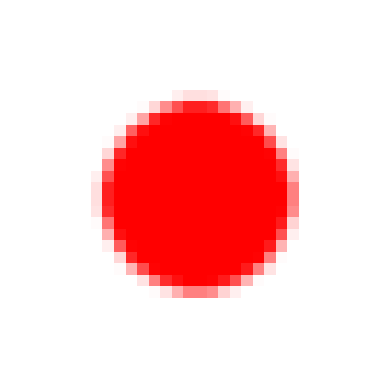

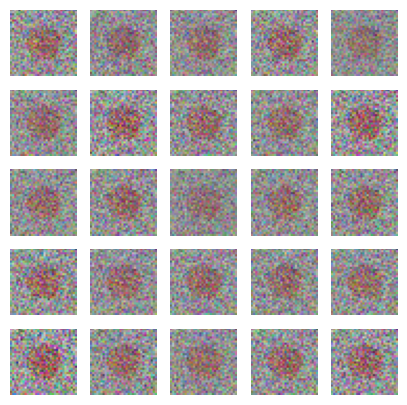

In [89]:
# --------- Inference Script ----------

# Ensure the model is in evaluation mode
generator.eval()

# Ask user input for image generation
input_text = input("Enter the text description for image generation (e.g., 'red circle'): ").lower()

# 1. Dataset and Dataloader
dataset = FilteredShapesDataset(csv_file="metadata.csv", img_dir="tiny_dataset", input_text=input_text, transform=transform)

if len(dataset) == 0:
    raise ValueError(f"No images found for description '{input_text}'")

# 2. Create a DataLoader for the filtered dataset (if you want to visualize the original dataset)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Show one example image from the filtered dataset
for idx, img in enumerate(dataloader):
    img = img[0].detach().cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # unnormalize

    plt.imshow(img)
    plt.axis('off')
    plt.show()
    break

# 3. Generate New Images Based on User Input
latent_dim = 100  # You can adjust the latent dimension as needed
z = torch.randn(25, latent_dim, device=device)  # Generate 25 new images
generated_images = generator(z)

# Unnormalize and display generated images
generated_images = generated_images * 0.5 + 0.5  # unnormalize

grid = torch.cat([img.unsqueeze(0) for img in generated_images], dim=0)
grid = torch.reshape(grid, (-1, 3, 32, 32))

fig, axs = plt.subplots(5, 5, figsize=(5, 5))
cnt = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(grid[cnt].permute(1,2,0).detach().cpu().numpy())
        axs[i,j].axis('off')
        cnt += 1
plt.show()

In [17]:
# 7. Save Trained Models
os.makedirs("saved_models", exist_ok=True)

generator_path = f"saved_models/generator_{input_text.replace(' ', '_')}.pth"
discriminator_path = f"saved_models/discriminator_{input_text.replace(' ', '_')}.pth"

torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)

print(f"\n✅ Models saved to:")
print(f"  - {generator_path}")
print(f"  - {discriminator_path}")


✅ Models saved to:
  - saved_models/generator_red_circle.pth
  - saved_models/discriminator_red_circle.pth


#Text2ImageTransformer

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training started...
Epoch 1, Loss: 0.2365
Epoch 2, Loss: 0.1829
Epoch 3, Loss: 0.1311
Epoch 4, Loss: 0.0962
Epoch 5, Loss: 0.0761
Epoch 6, Loss: 0.0650
Epoch 7, Loss: 0.0588
Epoch 8, Loss: 0.0538
Epoch 9, Loss: 0.0489
Epoch 10, Loss: 0.0446
Epoch 11, Loss: 0.0402
Epoch 12, Loss: 0.0363
Epoch 13, Loss: 0.0327
Epoch 14, Loss: 0.0292
Epoch 15, Loss: 0.0257
Epoch 16, Loss: 0.0228
Epoch 17, Loss: 0.0204
Epoch 18, Loss: 0.0183
Epoch 19, Loss: 0.0163
Epoch 20, Loss: 0.0148
✅ Model saved as text_to_image_model.pth
✅ Generated image saved as generated_image.png


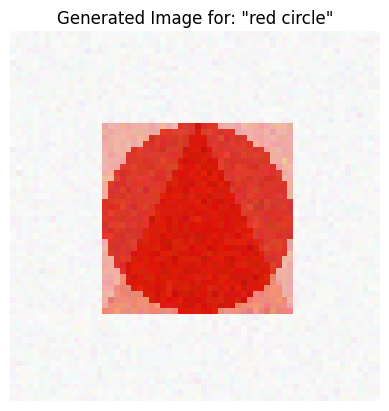

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# -----------------------
# Step 1: Tokenizer
# -----------------------
vocab = {
    "red": 1, "green": 2, "blue": 3,
    "circle": 4, "square": 5, "triangle": 6,
    "<PAD>": 0
}

def tokenizer(text, max_len=2):
    tokens = [vocab.get(word, 0) for word in text.lower().split()]
    if len(tokens) < max_len:
        tokens += [0] * (max_len - len(tokens))  # Pad
    return tokens[:max_len]

# -----------------------
# Step 2: Custom Dataset
# -----------------------
class ShapeDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["text"]
        image_path = os.path.join(self.image_dir, row["image"])

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        input_ids = tokenizer(text)
        return torch.tensor(input_ids).long(), image

# -----------------------
# Step 3: Model
# -----------------------
class TextToImageTransformer(nn.Module):
    def __init__(self, vocab_size=7, embed_dim=32, num_heads=2, hidden_dim=64):
        super(TextToImageTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=2
        )
        self.fc = nn.Linear(embed_dim, 3 * 64 * 64)

    def forward(self, input_ids):
        x = self.embedding(input_ids)  # (batch, seq_len, embed_dim)
        x = x.permute(1, 0, 2)         # Transformer expects (seq_len, batch, embed_dim)
        x = self.transformer(x)
        x = x.mean(dim=0)              # Global average pooling
        x = self.fc(x)
        x = x.view(-1, 3, 64, 64)      # Output image shape
        return torch.sigmoid(x)        # Scale to [0,1]

# -----------------------
# Step 4: Train
# -----------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ShapeDataset("metadata.csv", "tiny_dataset", transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextToImageTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training started...")
for epoch in range(1, 21):
    total_loss = 0
    for input_ids, real_imgs in dataloader:
        input_ids, real_imgs = input_ids.to(device), real_imgs.to(device)

        optimizer.zero_grad()
        output_imgs = model(input_ids)
        loss = criterion(output_imgs, real_imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss / len(dataloader):.4f}")

# -----------------------
# Step 5: Save Model
# -----------------------
torch.save(model.state_dict(), "text_to_image_model.pth")
print("✅ Model saved as text_to_image_model.pth")

# -----------------------
# Step 6: Inference + Save Image
# -----------------------
# Reload the model for inference
model.load_state_dict(torch.load("text_to_image_model.pth"))
model.eval()

prompt = "red circle"
tokens = tokenizer(prompt)
input_ids = torch.tensor(tokens).unsqueeze(0).long().to(device)

with torch.no_grad():
    generated_img = model(input_ids).squeeze(0).cpu().clamp(0, 1)

# Save to disk
save_image(generated_img, "generated_image.png")
print("✅ Generated image saved as generated_image.png")

# Display the result
plt.imshow(generated_img.permute(1, 2, 0).numpy())
plt.title(f'Generated Image for: "{prompt}"')
plt.axis('off')
plt.show()


# BERT


Epoch 1/30, Loss: 0.2248
Epoch 2/30, Loss: 0.2041
Epoch 3/30, Loss: 0.1300
Epoch 4/30, Loss: 0.0851
Epoch 5/30, Loss: 0.0708
Epoch 6/30, Loss: 0.0645
Epoch 7/30, Loss: 0.0600
Epoch 8/30, Loss: 0.0553
Epoch 9/30, Loss: 0.0501
Epoch 10/30, Loss: 0.0452
Epoch 11/30, Loss: 0.0416
Epoch 12/30, Loss: 0.0388
Epoch 13/30, Loss: 0.0372
Epoch 14/30, Loss: 0.0353
Epoch 15/30, Loss: 0.0353
Epoch 16/30, Loss: 0.0330
Epoch 17/30, Loss: 0.0314
Epoch 18/30, Loss: 0.0300
Epoch 19/30, Loss: 0.0290
Epoch 20/30, Loss: 0.0282
Epoch 21/30, Loss: 0.0278
Epoch 22/30, Loss: 0.0270
Epoch 23/30, Loss: 0.0262
Epoch 24/30, Loss: 0.0258
Epoch 25/30, Loss: 0.0251
Epoch 26/30, Loss: 0.0234
Epoch 27/30, Loss: 0.0214
Epoch 28/30, Loss: 0.0196
Epoch 29/30, Loss: 0.0178
Epoch 30/30, Loss: 0.0159


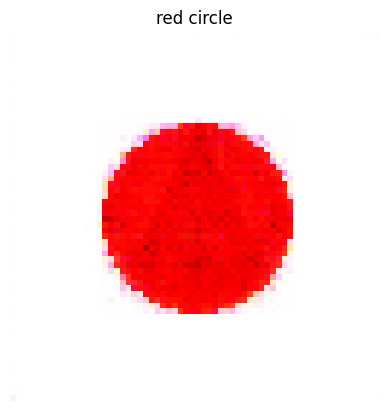

In [42]:
import os, random, torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from transformers import BertTokenizer, BertModel

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_dir = "tiny_dataset"
csv_path = "metadata.csv"

# ----------- DATASET ----------- #
class ShapesDataset(Dataset):
    def __init__(self, csv_path, img_dir, tokenizer, transform):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["text"]
        img_path = os.path.join(self.img_dir, row["image"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        tokens = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=16)
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0), image

# ----------- MODEL ----------- #
class TextToImageModel(nn.Module):
    def __init__(self):
        super(TextToImageModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),  # -> 64x64
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        encoded = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        x = self.fc(encoded).view(-1, 64, 8, 8)
        return self.deconv(x)

# ----------- TRAINING ----------- #
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for input_ids, attention_mask, images in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.4f}")

# ----------- INFERENCE ----------- #
def inference(model, tokenizer, description, device='cpu'):
    model.eval()
    with torch.no_grad():
        tokens = tokenizer(description, return_tensors='pt', padding='max_length', truncation=True, max_length=16)
        input_ids = tokens['input_ids'].to(device)
        attention_mask = tokens['attention_mask'].to(device)

        output = model(input_ids, attention_mask).squeeze(0)
        output = output.cpu().clamp(0, 1)
        image = transforms.ToPILImage()(output)
        return image

# ----------- RUN EVERYTHING ----------- #
# Load tokenizer, transform, dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ShapesDataset(csv_path, dataset_dir, tokenizer, transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize model
model = TextToImageModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
train(model, loader, criterion, optimizer, epochs=30)

# Save
torch.save(model.state_dict(), "bert_to_image.pth")

# Load
model.load_state_dict(torch.load("bert_to_image.pth", map_location=device))

# Inference
desc = "red circle"
gen_img = inference(model, tokenizer, desc, device)

# Display reliably
plt.imshow(gen_img)
plt.axis('off')
plt.title(desc)
plt.show()


# Evaluation Metrices

In [123]:
import os
import shutil
import pandas as pd
from PIL import Image

# Directories
dataset_dir = "tiny_dataset"
generated_images_dir = "generated_images"
real_images_dir = "real_images"

# Ensure directories exist
os.makedirs(real_images_dir, exist_ok=True)
os.makedirs(generated_images_dir, exist_ok=True)

# Load metadata
metadata = pd.read_csv("metadata.csv")

# Filter real images based on the description (e.g., "red circle")
target_description = "red circle"

# Extract real images corresponding to the target description
real_images = metadata[metadata["text"] == target_description]

for idx, row in real_images.iterrows():
    img_path = os.path.join(dataset_dir, row["image"])
    if os.path.exists(img_path):
        shutil.copy(img_path, real_images_dir)
generated_images_dict = {
    "CGAN": "/content/cgan_generated_red_circle.png",
    "VAE": "/content/cvae_generated_red_circle.png",
    "CNN_Decoder": "/content/generated_red_circle.png",
    "text2image transformer": "/content/generated_image.png",
    "BERT transformer": "/content/bert_generated_red_circle.png"
}

for model_name, generated_image_path in generated_images_dict.items():
    if os.path.exists(generated_image_path):
        shutil.copy(generated_image_path, generated_images_dir)

print(f"Real images for '{target_description}' saved in {real_images_dir}")
print(f"Generated images saved in {generated_images_dir}")

Real images for 'red circle' saved in real_images
Generated images saved in generated_images


In [112]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from scipy.stats import entropy
from tqdm import tqdm
from PIL import Image
import os

# Load InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def calculate_inception_score(image_paths, model=inception_model, splits=1):
    imgs = []

    if isinstance(image_paths, str):
        image_paths = [image_paths]

    for img_path in image_paths:
        if not os.path.isfile(img_path):
            continue
        img = image.load_img(img_path, target_size=(299, 299))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        imgs.append(img)

    imgs = np.array(imgs)

    preds = model.predict(imgs, batch_size=8)
    scores = []

    for i in range(splits):
        part = preds[i * len(preds) // splits: (i+1) * len(preds) // splits]
        kl = part * (np.log(part + 1e-10) - np.log(np.expand_dims(np.mean(part, 0), 0) + 1e-10))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))

    return float(np.mean(scores))


def evaluate_models(real_images_df, generated_images_dict):
    results = {
        "Inception Score (IS)": {},
        # You can add more metrics like FID, SSIM, etc.
    }

    for model_name, gen_img_path in generated_images_dict.items():
        score = calculate_inception_score(gen_img_path)
        results["Inception Score (IS)"][model_name] = round(score, 4)

    return results

In [114]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from PIL import Image

def evaluate_ssim_psnr(real_dir, generated_dict):
    results = {
        "SSIM": {},
        "PSNR": {}
    }

    real_images = [Image.open(os.path.join(real_dir, f)).convert('RGB') for f in os.listdir(real_dir) if f.endswith('.png')]
    if not real_images:
        print("No real images found.")
        return results

    real_np = np.mean([np.array(img.resize((64, 64))) for img in real_images], axis=0).astype(np.uint8)

    for model_name, gen_path in generated_dict.items():
        if os.path.exists(gen_path):
            gen_img = Image.open(gen_path).convert('RGB').resize((64, 64))
            gen_np = np.array(gen_img)

            ssim_score = ssim(real_np, gen_np, channel_axis=2)
            psnr_score = psnr(real_np, gen_np)

            results["SSIM"][model_name] = round(ssim_score, 4)
            results["PSNR"][model_name] = round(psnr_score, 2)
        else:
            results["SSIM"][model_name] = "Not Found"
            results["PSNR"][model_name] = "Not Found"

    return results

In [116]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm

def image_to_embedding(image_paths, model, image_size=(299, 299)):
    embeddings = []
    for path in image_paths:
        img = Image.open(path).convert('RGB').resize(image_size)
        img_array = np.array(img).astype(np.float32)
        img_array = preprocess_input(img_array)
        embeddings.append(img_array)
    embeddings = np.array(embeddings)
    preds = model.predict(embeddings, verbose=0)
    return preds

def calculate_fid(real_dir, generated_dict):
    fid_scores = {}
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Get real image paths
    real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.png')]
    real_embeddings = image_to_embedding(real_paths, model)

    for model_name, gen_path in generated_dict.items():
        if not os.path.exists(gen_path):
            fid_scores[model_name] = "Not Found"
            continue

        gen_embeddings = image_to_embedding([gen_path], model)

        # Calculate statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = gen_embeddings.mean(axis=0), np.cov(gen_embeddings, rowvar=False)

        # Compute FID
        ssdiff = np.sum((mu1 - mu2) ** 2)
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
        fid_scores[model_name] = round(fid, 3)

    return fid_scores

In [ ]:
def human_evaluation(generated_dict):
    print("Human Evaluation: Rate from 1 (Poor) to 5 (Excellent)")
    evaluation = {}

    for model_name, img_path in generated_dict.items():
        if not os.path.exists(img_path):
            evaluation[model_name] = {"realism": "Not Found", "variety": "Not Found", "relevance": "Not Found"}
            continue

        print(f"\nModel: {model_name}")
        img = Image.open(img_path)
        img.show()

        realism = int(input("Realism (1-5): "))
        variety = int(input("Variety (1-5): "))
        relevance = int(input("Relevance to prompt (1-5): "))

        evaluation[model_name] = {
            "realism": realism,
            "variety": variety,
            "relevance": relevance
        }

    return evaluation


In [118]:
evaluation_results = evaluate_models(real_images, generated_images_dict)
ssim_psnr_results = evaluate_ssim_psnr(real_images_dir, generated_images_dict)
fid_scores = calculate_fid(real_images_dir, generated_images_dict)
#human_scores = human_evaluation(generated_images_dict)

print("Evaluation Results:")
for metric, scores in evaluation_results.items():
    print(f"\n{metric}:")
    for model, score in scores.items():
        print(f"{model}: {score}")

for metric, scores in ssim_psnr_results.items():
    print(f"\n{metric}:")
    for model, score in scores.items():
        print(f"{model}: {score}")

fid_results = calculate_fid("real_images", generated_images_dict)
print("FID Scores:")
for model, score in fid_results.items():
    print(f"{model}: {score}")

'''
for model, scores in human_scores.items():
    print(f"\n{model}:")
    for metric, score in scores.items():
        print(f"{metric}: {score}")
        '''

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Failed to find a square root.
Failed to find a square root.
Evaluation Results:

Inception Score (IS):
CGAN: 1.0
VAE: 1.0
CNN_Decoder: 1.0
text2image transformer: 1.0
BERT transformer: 1.0

SSIM:
CGAN: 0.9132
VAE: 0.9978
CNN_Decoder: 0.8029
text2image transformer: 0.6587
BERT transformer: 0.8066

PSNR:
CGAN: 20.81
VAE: 55.73
CNN_Decoder: 27.04
text2image transformer: 19.42
BERT transformer: 17.61


Failed to find a square root.
Failed to find a square root.
FID Scores:
CGAN: nan
VAE: nan
CNN_Decoder: nan
text2image transformer: nan
BERT transformer: nan


'\nfor model, scores in human_scores.items():\n    print(f"\n{model}:")\n    for metric, score in scores.items():\n        print(f"{metric}: {score}")\n        '

<ipython-input-122-6ed6e9fdf956>:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(models, rotation=15)
<ipython-input-122-6ed6e9fdf956>:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(models, rotation=15)


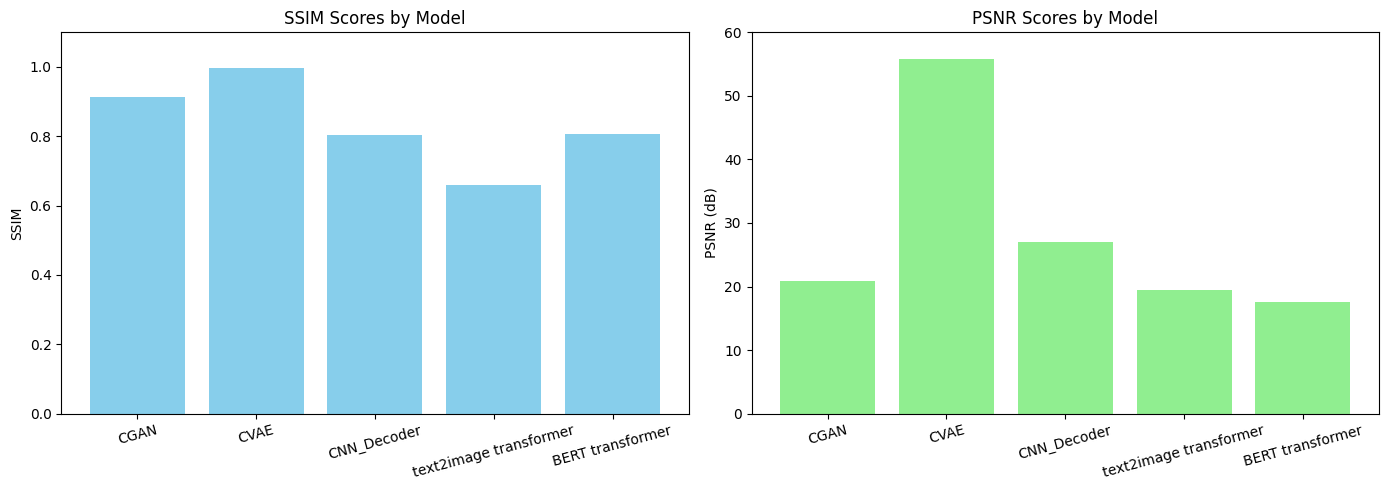


Conclusion:
Based on the highest SSIM (0.9978), the best model is CVAE.
Based on the highest PSNR (55.73), the best model is CVAE.
Overall, **CVAE** performs the best based on both SSIM and PSNR.


In [122]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

def evaluate_ssim_psnr(real_dir, generated_dict):
    results = {
        "SSIM": {},
        "PSNR": {}
    }

    real_images = [Image.open(os.path.join(real_dir, f)).convert('RGB') for f in os.listdir(real_dir) if f.endswith('.png')]
    if not real_images:
        print("No real images found.")
        return results

    # Resize the real images to 64x64 for comparison
    real_np = np.mean([np.array(img.resize((64, 64))) for img in real_images], axis=0).astype(np.uint8)

    # Evaluate SSIM and PSNR for each generated model
    for model_name, gen_path in generated_dict.items():
        if os.path.exists(gen_path):
            gen_img = Image.open(gen_path).convert('RGB').resize((64, 64))
            gen_np = np.array(gen_img)

            ssim_score = ssim(real_np, gen_np, channel_axis=2)
            psnr_score = psnr(real_np, gen_np)

            results["SSIM"][model_name] = round(ssim_score, 4)
            results["PSNR"][model_name] = round(psnr_score, 2)
        else:
            results["SSIM"][model_name] = "Not Found"
            results["PSNR"][model_name] = "Not Found"

    return results

# Directories
real_images_dir = "real_images"
generated_images_dict = {
    "CGAN": "/content/cgan_generated_red_circle.png",
    "CVAE": "/content/cvae_generated_red_circle.png",
    "CNN_Decoder": "/content/generated_red_circle.png",
    "text2image transformer": "/content/generated_image.png",
    "BERT transformer": "/content/bert_generated_red_circle.png"
}

# Evaluate SSIM and PSNR
ssim_psnr_results = evaluate_ssim_psnr(real_images_dir, generated_images_dict)

# Extract SSIM and PSNR scores for plotting
ssim_scores = list(ssim_psnr_results["SSIM"].values())
psnr_scores = list(ssim_psnr_results["PSNR"].values())
models = list(ssim_psnr_results["SSIM"].keys())

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# SSIM chart
ax[0].bar(models, ssim_scores, color='skyblue')
ax[0].set_title('SSIM Scores by Model')
ax[0].set_ylabel('SSIM')
ax[0].set_ylim(0, 1.1)
ax[0].set_xticklabels(models, rotation=15)

# PSNR chart
ax[1].bar(models, psnr_scores, color='lightgreen')
ax[1].set_title('PSNR Scores by Model')
ax[1].set_ylabel('PSNR (dB)')
ax[1].set_ylim(0, 60)
ax[1].set_xticklabels(models, rotation=15)

plt.tight_layout()
plt.show()

# Find best model based on highest SSIM and PSNR
best_index_ssim = ssim_scores.index(max(ssim_scores))
best_index_psnr = psnr_scores.index(max(psnr_scores))

best_model_ssim = models[best_index_ssim]
best_model_psnr = models[best_index_psnr]

# Conclusion
print("\nConclusion:")
print(f"Based on the highest SSIM ({ssim_scores[best_index_ssim]}), the best model is {best_model_ssim}.")
print(f"Based on the highest PSNR ({psnr_scores[best_index_psnr]}), the best model is {best_model_psnr}.")

# Find the overall best model considering both SSIM and PSNR
if best_model_ssim == best_model_psnr:
    print(f"Overall, **{best_model_ssim}** performs the best based on both SSIM and PSNR.")
else:
    print(f"Overall, there is no clear best model based on both SSIM and PSNR. SSIM suggests {best_model_ssim} and PSNR suggests {best_model_psnr}.")
